In [1]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import special
from LPModel import *
from scipy.special import*

# ShortRangeCoulombCollisions
##Rho(u*ProjectileVelocity)[0]/Rho(u*ProjectileVelocity)[0]

class Particles(object):
        
    hbar = 1.054571e-27
    amu = 1.6726219e-24   # Unit: gram
    eMass = 9.10938356e-28 # Unit: gram
    Boltz = 1.38065e-16    #  cm2 g s2 K-1
    e = 4.80319685e-10     #statcoulomb
    eLH = e*np.sqrt(4*np.pi) # convert to Lorentz-Heaviside Unit Bacically, decrease the field by np.sqrt(4*np.pi) 
    eVToKelvin = 11604.5    # increase the charge by a factor of np.sqrt(4*np.pi)
    MeVToErg = 1.6021773e-6  # MeV to cgs unit energy centimetre–gram–second
    CGSToMeVum = 1/1.6021773e-6/1e4           # This unit still in MeV, do not need convert the unit
    
    def __init__(self, PN, Mass, Charge, Tempe, Density):
        if PN > 0 :
            self.Mass = Mass*self.amu
            self.Charge = Charge*self.eLH
            self.NumDensity = Density/self.Mass
        else:
            self.Mass = self.eMass
            self.Charge = self.eLH
            self.NumDensity = Density/(Mass*self.amu)*Charge
                
        self.Tempe = Tempe*self.eVToKelvin
        self.Beta = 1 / (self.Boltz*self.Tempe)
        self.DebyeK = np.sqrt(self.Beta*self.Charge**2*self.NumDensity)
        self.ThermalVelocity = np.sqrt(2*self.Boltz*self.Tempe/self.Mass)
        
    def CSIntegration(self, ProjectileMass, ProjectileVelocity, ProjectileCharge):
        self.RelativeMass = self.Mass*ProjectileMass/(self.Mass + ProjectileMass)
        kernel = lambda u: np.sqrt(u)*np.exp(-self.Beta*self.Mass*ProjectileVelocity**2*u/2)*(\
(-np.log(self.Beta*ProjectileCharge*self.Charge*self.DebyeK/(4*np.pi)*(self.Mass/self.RelativeMass)*(u/(1-u)))+\
2-2*0.5772)*(self.Beta*(self.Mass+ProjectileMass)*ProjectileVelocity**2 - 1/u) + 2/u)
        return integrate.quad(kernel, 0.00001, 0.99999)[0]

    def QuantumCorrection (self, PM, PV, PC):
        self.Vtf = np.absolute(PV - self.ThermalVelocity)

        kernel = lambda u: (2*np.real(digamma(complex(1,self.Etatf(u, PC))))-2*np.log(self.Etatf(u, PC)))*\
            (self.Minus(u, PV, PM)*self.ExpMinus(u, PV)-self.Add(u, PV, PM)*self.ExpAdd(u, PV))
       
        Vmin = min(PV, self.Vtf)/5
        Vmax = max(PV, self.Vtf)*5
        
        return integrate.quad(kernel, Vmin, Vmax)[0]

    def Etatf (self, u, PC):
        return self.Charge*PC/(4*np.pi*self.hbar*u)
    
    def ExpMinus(self, u, PV):
        return np.exp(-0.5*self.Beta*self.Mass*(PV-u)**2)
    def ExpAdd(self, u, PV):
        return np.exp(-0.5*self.Beta*self.Mass*(PV+u)**2)
    def Minus(self, u, PV, PM):
        return 1+(self.Mass+PM)/self.Mass*PV/u*\
                                (1/(self.Beta*self.Mass*PV*u)-1) 
    def Add(self, u, PV, PM):
        return 1+(self.Mass+PM)/self.Mass*PV/u*\
                                (1/(self.Beta*self.Mass*PV*u)+1) 
    
def Rho(u) :
    ECrho = Electrons.DebyeK**2*np.sqrt(Electrons.Beta*Electrons.Mass/(2*np.pi))
    ECa = Electrons.Beta*Electrons.Mass/2
    ICrho = Ions.DebyeK**2*np.sqrt(Ions.Beta*Ions.Mass/(2*np.pi))
    ICa = Ions.Beta*Ions.Mass/2
    
    Erho = ECrho*u*np.exp(-ECa*u**2)
    Irho = ICrho*u*np.exp(-ICa*u**2)
    rhotot = Erho+Irho
    return Erho, Irho, rhotot

def MyFfunc(x):  #Total, sum of electron effects and ion effects
    ECrho = Electrons.DebyeK**2*np.sqrt(Electrons.Beta*Electrons.Mass/(2*np.pi))
    ECa = Electrons.Beta*Electrons.Mass/2
    ICrho = Ions.DebyeK**2*np.sqrt(Ions.Beta*Ions.Mass/(2*np.pi))
    ICa = Ions.Beta*Ions.Mass/2
    pole = complex(x, 1e-6)
    Ffunction = -(ECrho*2*np.pi*complex(0,1)*np.exp(-ECa*pole**2)*pole+\
                    ICrho*2*np.pi*complex(0,1)*np.exp(-ICa*pole**2)*pole)
    return Ffunction

def Ffunc(x):  #Total, sum of electron effects and ion effects
    ECrho = Electrons.DebyeK**2*np.sqrt(Electrons.Beta*Electrons.Mass/(2*np.pi))
    ECa = Electrons.Beta*Electrons.Mass/2
    ICrho = Ions.DebyeK**2*np.sqrt(Ions.Beta*Ions.Mass/(2*np.pi))
    ICa = Ions.Beta*Ions.Mass/2
    pole = complex(x, 1e-6)
    Eerfi = erfi(np.sqrt(ECa)*pole)
    Ierfi = erfi(np.sqrt(ICa)*pole)
    EFfunction = ECrho*(-np.sqrt(np.pi/ECa)+np.exp(-ECa*pole**2)*pole*(np.pi*Eerfi+np.log(-pole)-np.log(pole)))
    if np.isinf(Ierfi):
        IFfunction = 0
    else:
        IFfunction = ICrho*(-np.sqrt(np.pi/ICa)+np.exp(-ICa*pole**2)*pole*(np.pi*Ierfi+np.log(-pole)-np.log(pole))) 
    Ffunction = EFfunction+IFfunction
    return Ffunction
#Condition Initialization      

Ions = Particles(PN = 1, Mass=9,Charge=4,Tempe=50,Density=1.78)
Electrons = Particles(PN = 0, Mass=9,Charge=4,Tempe=50,Density=1.78)

ProjectileMass= 1*Ions.amu 
ProjectileCharge = 1*Ions.eLH

InputProjectileEnergy = 13 #MeV
ProjectileEnergy = InputProjectileEnergy*Ions.MeVToErg  # Unit: MeV to eng
    
E0 = ProjectileEnergy
V0 = np.sqrt(2*E0/ProjectileMass)

####Try to write the integration ###

def dEdxCR(V0):
    Integration = 0
    for i in range(200):
        U = (-1+0.01*i)
        u = (-1+0.01*i)*V0
        if u!=0:
            kernel = U*Ffunc(u)*np.log(Ffunc(u)/Electrons.DebyeK**2)*Rho(u)[0]/Rho(u)[2]
        Integration+= kernel*0.01
    Fcombi = Ffunc(V0)*np.log(Ffunc(V0)/Electrons.DebyeK**2)-np.conj(Ffunc(V0))*np.log(np.conj(Ffunc(V0))/Electrons.DebyeK**2)
    ElectrondEdxCR = ProjectileCharge**2/(4*np.pi)/(2*np.pi)*(Integration  - \
                                   1/(Electrons.Beta*ProjectileMass*V0**2)*Fcombi)*Electrons.CGSToMeVum
    return ElectrondEdxCR


Integration = 0
for i in range(200):
    U = (-1+0.01*i)
    u = (-1+0.01*i)*V0
    if u!=0:
        kernel = U*Ffunc(u)*np.log(Ffunc(u)/Electrons.DebyeK**2)*Rho(u)[0]/Rho(u)[2]
    Integration+= kernel*0.01
Fcombi = Ffunc(V0)*np.log(Ffunc(V0)/Electrons.DebyeK**2)-np.conj(Ffunc(V0))*np.log(np.conj(Ffunc(V0))/Electrons.DebyeK**2)
ElectrondEdxCR = ProjectileCharge**2/(4*np.pi)/(2*np.pi)*(Integration  - \
                                   1/(Electrons.Beta*ProjectileMass*V0**2)*Fcombi)*Electrons.CGSToMeVum

print(ElectrondEdxCR)


(1.02245205025e-05+0.000326336706677j)


<IPython.core.display.Javascript object>


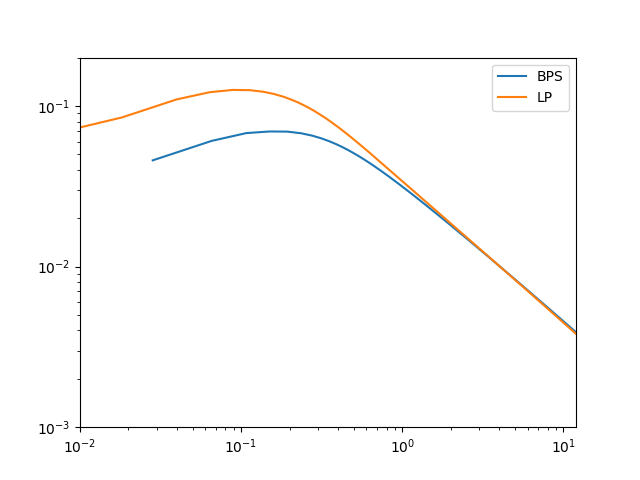

In [10]:
ENextAU = InputProjectileEnergy
DistanceStep = 0.0001

#Calculating the SP 
PEnergy = []
StopPow = []
Quantum = []
Lratio = []
dEdx =0
 
for i in range (0,60000):
    ENextAU = ENextAU - dEdx*DistanceStep*i
    if ENextAU < 0:
        break
    ENext = ENextAU*Ions.MeVToErg  # Unit: MeV to eng
    VNext = np.sqrt(2*ENext/ProjectileMass)
    ratio = VNext/Electrons.ThermalVelocity

    IonsCSIntegration = Ions.CSIntegration(ProjectileMass, VNext, ProjectileCharge)
    ElectronsCSIntegration = Electrons.CSIntegration(ProjectileMass, VNext, ProjectileCharge)

    IondEdxCS = ProjectileCharge**2/(4*np.pi)*Ions.DebyeK**2/(ProjectileMass*VNext)*\
                        np.sqrt(Ions.Mass/(2*np.pi*Ions.Beta))*IonsCSIntegration*Ions.CGSToMeVum
    ElectrondEdxCS = ProjectileCharge**2/(4*np.pi)*Electrons.DebyeK**2/(ProjectileMass*VNext)*\
                np.sqrt(Electrons.Mass/(2*np.pi*Electrons.Beta))*ElectronsCSIntegration*Electrons.CGSToMeVum
    
    EQdEdx = ProjectileCharge**2/(4*np.pi)*Electrons.DebyeK**2/(2*Electrons.Beta*ProjectileMass*VNext**2)*\
                                    np.sqrt(Electrons.Beta*Electrons.Mass/(2*np.pi))*\
                    Electrons.QuantumCorrection(ProjectileMass, VNext, ProjectileCharge)*Electrons.CGSToMeVum
        
    IQdEdx = ProjectileCharge**2/(4*np.pi)*Ions.DebyeK**2/(2*Ions.Beta*ProjectileMass*VNext**2)*\
                                    np.sqrt(Ions.Beta*Ions.Mass/(2*np.pi))*\
                    Ions.QuantumCorrection(ProjectileMass, VNext, ProjectileCharge)*Ions.CGSToMeVum
    
    dEdx = IondEdxCS+ElectrondEdxCS+EQdEdx+IQdEdx#+np.imag(dEdxCR(VNext))
#    dEdx = IondEdxCS+ElectrondEdxCS
    PEnergy.append(ENextAU)
    StopPow.append(dEdx)
#    Quantum.append(QdEdx)
    Lratio.append(ratio)
plt.loglog(PEnergy, StopPow, label='BPS')

PEnergyLP, StopPowLP, LratioLP = LP(1, 1, FieldDensity=1.78, FieldTem=50, FieldCharge=4, FieldMass=9, ProjE=13,ProjM=1,ProjC=1 )
plt.loglog(PEnergyLP, StopPowLP, label='LP')
plt.ylim(0.001, 0.2)
plt.xlim(0.01,12)
plt.legend()

In [3]:
plt.savefig('BPS.pdf')

In [4]:
x=float('inf')
math.isnan(x)

False